# European Electricity Data Preliminary Analysis


**Data source and dictionary:** https://data.open-power-system-data.org/time_series/2019-06-05 

### Data Sources
Internet Source: https://github.com/LSB-dev/Publicly-Available-Datasets-For-Electric-Load-Forecasting?tab=readme-ov-file

Citation(s): 
- Baur, L.; Chandramouli, V.; Sauer, A.: Publicly Available Datasets For Electric Load Forecasting – An Overview. In: Herberger, D.; Hübner, M. (Eds.): Proceedings of the CPSL 2024. Hannover : publish-Ing., 2024, S. 1-12. DOI: https://doi.org/10.15488/17659

- Open Power System Data. 2020. Data Package Time series. Version 2020-10-06. https://doi.org/10.25832/time_series/2020-10-06. (Primary data from various sources, for a complete list see URL).

Details on how the Data was processed:
https://github.com/Open-Power-System-Data/time_series/blob/885c0946fe57d1a2f44f7bc57306e87811e4e2e8//processing.ipynb

### Setup

In [3]:
### Import packages
import pandas as pd
import missingno
from datetime import datetime
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import pickle

# Notebook Config
%config InteractiveShell.ast_node_interactivity = 'all'

# Data Dictionary
# https://data.open-power-system-data.org/time_series/2019-06-05


In [37]:
# Functions
def country_level_variables(df, load_only=False):
    '''
    Description: Takes dataframe of variables and seperates them in groups 
    according to the first two letters of the variable.

    Inputs: Energy Dataframe
        load_only: To ONLY include the load_actual_entsoe_transparency variable 
        for a country instead of all variables. 
    Output: Dictionary of countries and their associated variables
    '''
    # Get all unique two-letter prefixes
    countries = set(col[:2] for col in df.columns if col not in ['utc_timestamp', 'cet_cest_timestamp'])
    
    # Dictionary to store results
    group_dfs = {}
    
    if load_only:
        for country in countries:
            # Load actual variable
            load_only_var = country + '_load_actual_entsoe_transparency'

            # Variables to subset to
            all_cols = ['utc_timestamp', load_only_var]
            
            # Create dataframe for country and assign to dictionary
            group_df = df[all_cols].copy() 
            group_dfs[country] = pd.DataFrame(group_df)
            
            # Create global variable for each group
            globals()[country] = group_df

    else:
        # Create dataframe for each prefix
        for country in countries:
            # Get columns that start with the prefix
            country_cols = [col for col in df.columns if col.startswith(country)]
            
            # Add time variables
            time_col = ['utc_timestamp']
            all_cols = time_col + country_cols
            
            # Create dataframe for country and assign to dictionary
            group_df = df[all_cols].copy() 
            group_dfs[country] = pd.DataFrame(group_df)
            
            # Create global variable for each group
            globals()[country] = group_df
    
    return group_dfs #pd.DataFrame(group_dfs)

def country_missing_dt(country_dfs):
    '''
    Description: Create missing data plots per country

    Input: Dictionary of countries and their data 
          (from country_level_variables function)
    Output: Graphs of missing data by variable
    '''
    for country, data in country_dfs.items():
        # Ensure data is ordered
        data = data.sort_values(by='utc_timestamp')
        # Return missing data for given country
        print(f"Country: {country} has {data.shape[1]} columns")
        missingno.matrix(data, figsize=(8,5), fontsize=12)

def add_time_features(df): # requires country_actuals dataframe
    '''
    Description: Given country_actuals dataset derived from 
    country_level_variables method + .reset_index(), adds
    several simple time features ('day', 'hour', 'month'
    'is_weekend' indicator, and 'is_holiday' indicator)
    '''
    us_holidays = holidays.US(years=range(2014, 2021))
    # day level date
    df['day'] = df['utc_timestamp'].dt.date
    # hour
    df['hour'] = df['utc_timestamp'].dt.hour
    # week of year
    df['week_of_year'] = df['utc_timestamp'].dt.isocalendar().week
    # month
    df['month'] = df['utc_timestamp'].dt.month
    # year
    df['year'] = df['utc_timestamp'].dt.year
    # weekend indicator variable
    df['is_weekend'] = df['utc_timestamp'].dt.dayofweek.isin([5, 6]).astype(int)
    # holiday indicator variable
    df['is_holiday'] = df['utc_timestamp'].dt.date.isin(us_holidays).astype(int)

    return df

def hourly_pivot(df): # requires country actuals
    '''
    Description: pivots table long-ways, with country and aggregated hourly 
    actuals load as columns
    '''
    return (df.pivot_table(index=['day', 'country'], 
                        values='load_actual_entsoe_transparency', 
                        columns = 'hour', 
                        aggfunc='sum')
                        # remove first day with NaNs
            .dropna()
            .reset_index(level=1))

def plot_norm_avg_hourly(df, group, pivot=True): # requires df from hourly_pivot function
    '''
    Description: min-max normalization of input data across each hour
    '''
    df = df.groupby(by=group, as_index=True).mean(numeric_only=True).round(2) # .reset_index()
    # hour columns
    cols = list(range(24))

    # columns for row-wise min-max normalization
    df['min'] = df[cols].min(axis=1)
    df['max'] = df[cols].max(axis=1)

    # Row-wise Min-max normalization 
    df[cols] = (df[cols].sub(df['min'], axis=0)
                        .div(df['max'] - df['min'], axis=0))
    
    # Melt for overlapping lineplots
    if pivot:
        df = (df.reset_index()
                .melt(id_vars=group,
                    value_vars=cols)
                .assign(hour = lambda x: pd.to_numeric(x.hour))
                )
        
    return df

def multi_lineplots(plot_df, group): # requires df from norm_avg_hourly function  
    '''
    Description: Creates overlapping line plots for each country given a dataframe
    from the 'norm_avg_hourly' function.
    '''
    colors = sns.color_palette('magma')
    _ = plt.figure(figsize=(10, 6))

    # Create dataset and plot for each time series in group
    for grouping, color in zip(plot_df[group].unique(), colors):
        line_plot = (plot_df[plot_df[group] == grouping])
        _ = sns.lineplot(
            data=line_plot,
            x='hour',
            y='value',
            color=color,
            label = str(grouping)
        )
    _ = plt.xlabel('Hour')
    _ = plt.ylabel('Normalized Load Actual')
    _ = plt.title(f'Avg Load Shapes by {group} 2015-2019')
        
    plt.show()


Read in Data

In [18]:
# Read in Data
cd = Path.cwd()
data_dir = str(cd.parents[1])
energy_15_raw = pd.read_csv(data_dir + "/datasets/country_energy/time_series_15min_singleindex.csv")
energy_15_raw.shape
energy_15_raw.head(5)

(502372, 77)

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_wind_onshore_capacity,...,HU_load_actual_entsoe_transparency,HU_load_forecast_entsoe_transparency,HU_wind_onshore_generation_actual,LU_load_actual_entsoe_transparency,LU_load_forecast_entsoe_transparency,NL_load_actual_entsoe_transparency,NL_load_forecast_entsoe_transparency,NL_solar_generation_actual,NL_wind_offshore_generation_actual,NL_wind_onshore_generation_actual
0,2004-12-31T23:00:00Z,2005-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-12-31T23:15:00Z,2005-01-01T00:15:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-12-31T23:30:00Z,2005-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-12-31T23:45:00Z,2005-01-01T00:45:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-01T00:00:00Z,2005-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


See countries, assess missing data per country

,Country,Abbreviation
0,Netherlands,NL
1,Luxembourg,LU
2,Austria,AT
3,Hungary,HU
4,Belgium,BE
5,Germany,DE


Country: DE has 56 columns
Country: BE has 6 columns
Country: HU has 4 columns
Country: NL has 6 columns
Country: LU has 3 columns
Country: AT has 6 columns


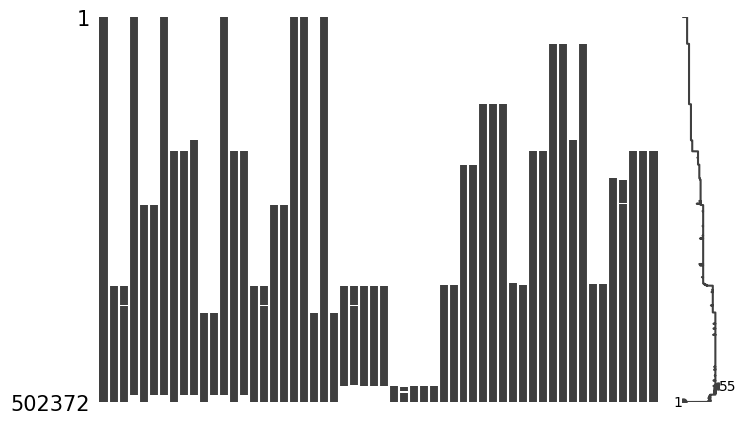

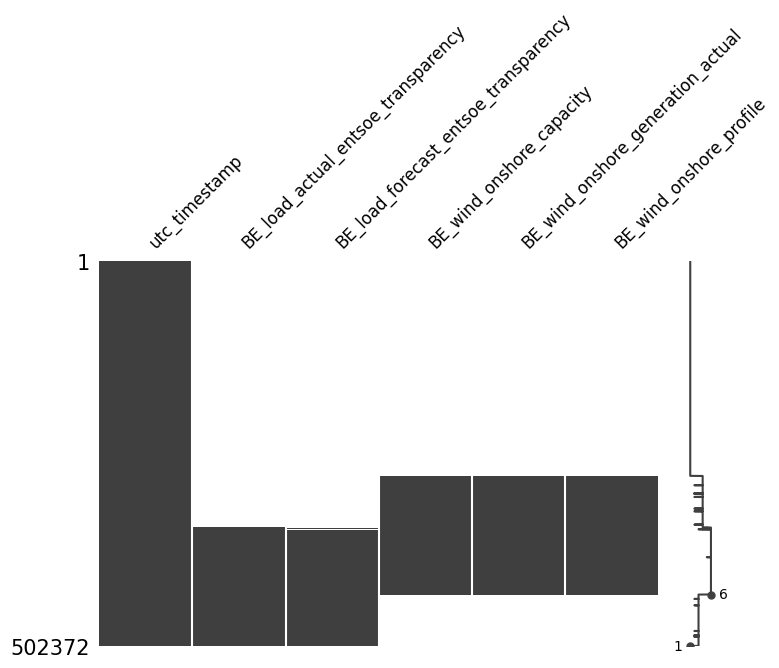

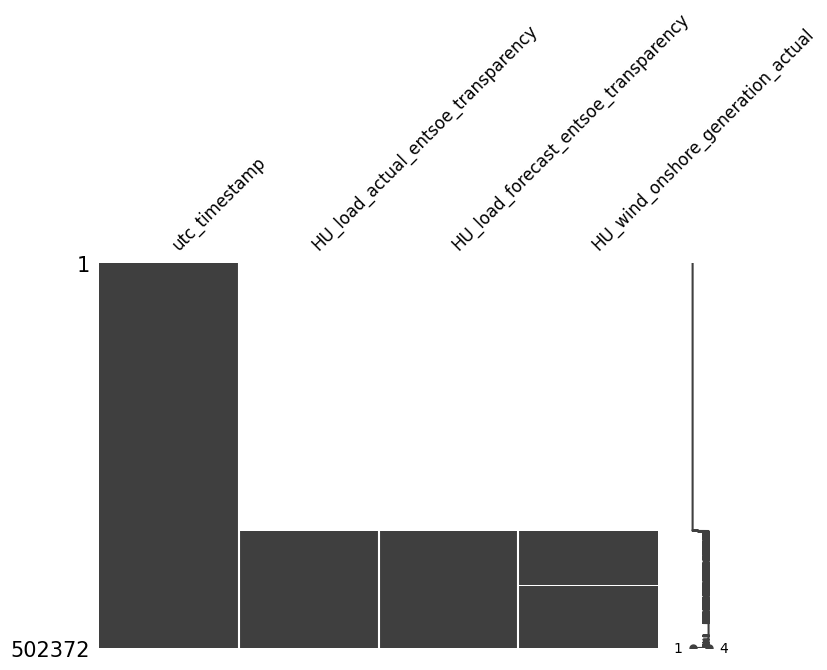

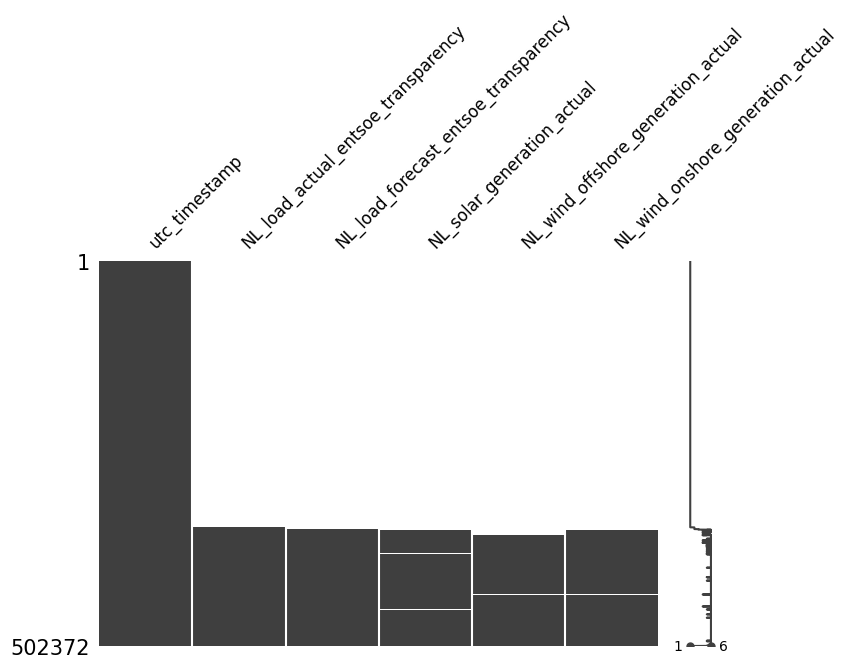

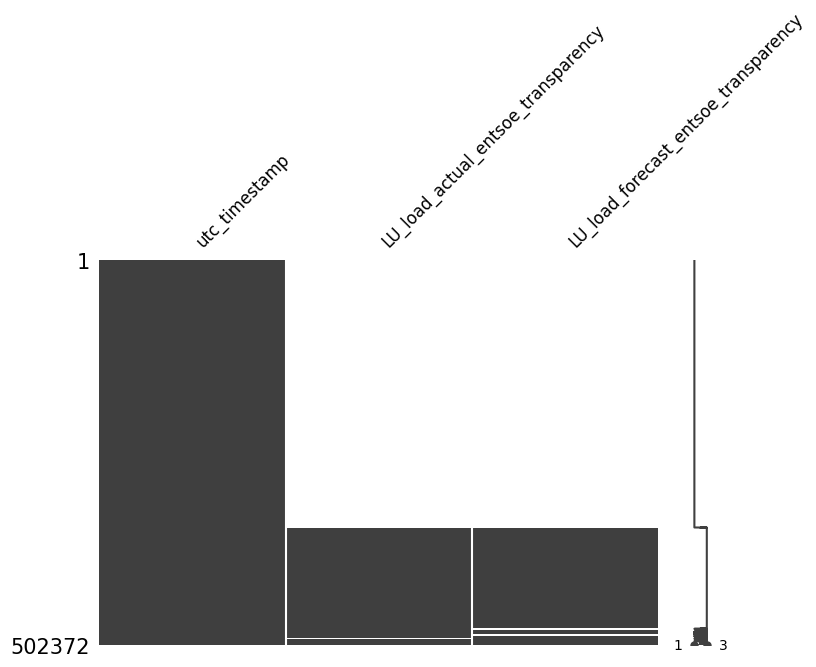

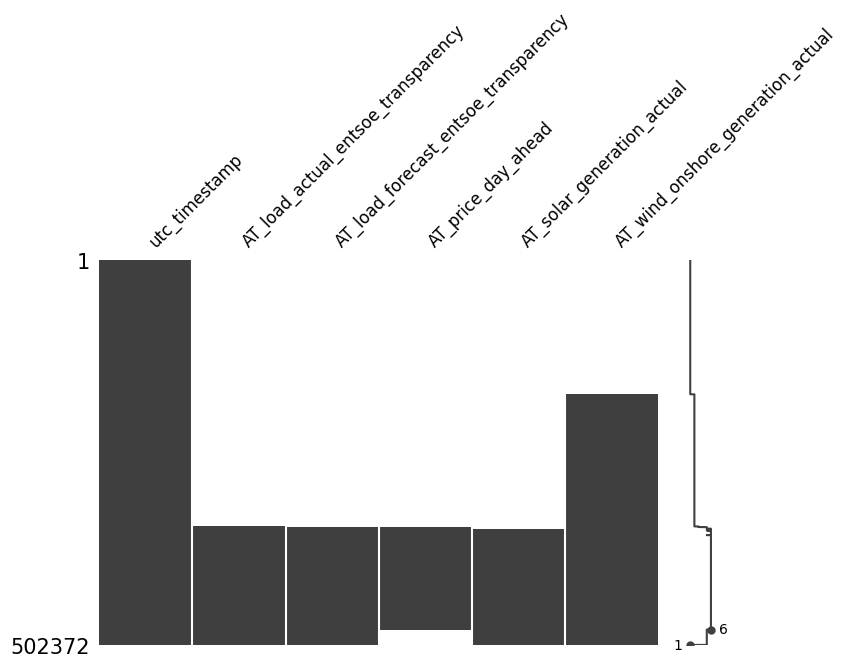

In [19]:
list_countries = pd.DataFrame({
'Country': ['Netherlands', 'Luxembourg', 'Austria', 'Hungary', 'Belgium', 'Germany'],
'Abbreviation': ['NL', 'LU', 'AT', 'HU', 'BE', 'DE']
})

list_countries

country_dfs = country_level_variables(energy_15_raw)
country_missing_dt(country_dfs)

Limit data to where there is available load_actuals across countries

In [20]:
# Get minimum lower bound time data available for each country
lower_bounds = []
for abbreviation, data in country_dfs.items():
    var = abbreviation + '_load_actual_entsoe_transparency'
    # "First Data Available (fdw)" data
    fdw_data = country_dfs[abbreviation][[var, 'utc_timestamp']].dropna()
    data_start = min(fdw_data.utc_timestamp)
    # Eariest datetime where data is available
    lower_bound_row = fdw_data[fdw_data['utc_timestamp']==data_start].index.values.astype(int)[0]
    lower_bounds.append(lower_bound_row)

print(f"First row of available data: {lower_bounds}")

# max row number is the minimum utc_timestamp with data available
energy_15_bounded = energy_15_raw.iloc[max(lower_bounds):] 
energy_15_bounded.shape
print(f'Days of data available: {energy_15_bounded.shape[0] / (4 * 24):.2f}\nYears of data available: {energy_15_bounded.shape[0] / (4 * 24 * 365):.2f}')
print(f"Data range from {energy_15_bounded['utc_timestamp'].min()} to {energy_15_bounded['utc_timestamp'].max()}")


First row of available data: [350593, 347621, 349729, 347621, 349101, 347713]


(151779, 77)

Days of data available: 1581.03
Years of data available: 4.33
Data range from 2014-12-31T23:15:00Z to 2019-04-30T23:45:00Z


Country: DE has 56 columns
Country: BE has 6 columns
Country: HU has 4 columns
Country: NL has 6 columns
Country: LU has 3 columns
Country: AT has 6 columns


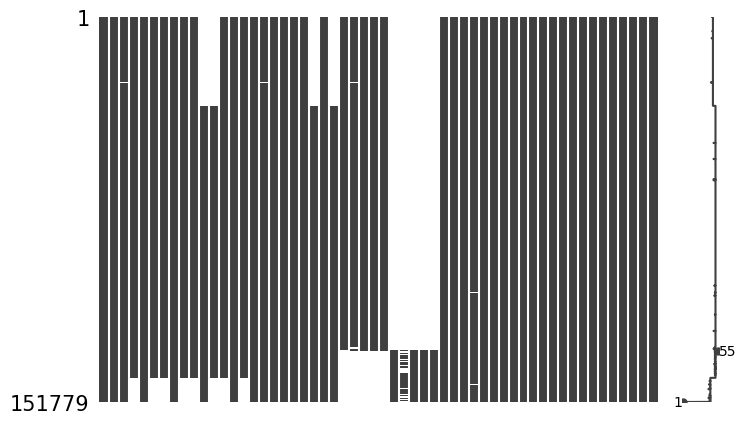

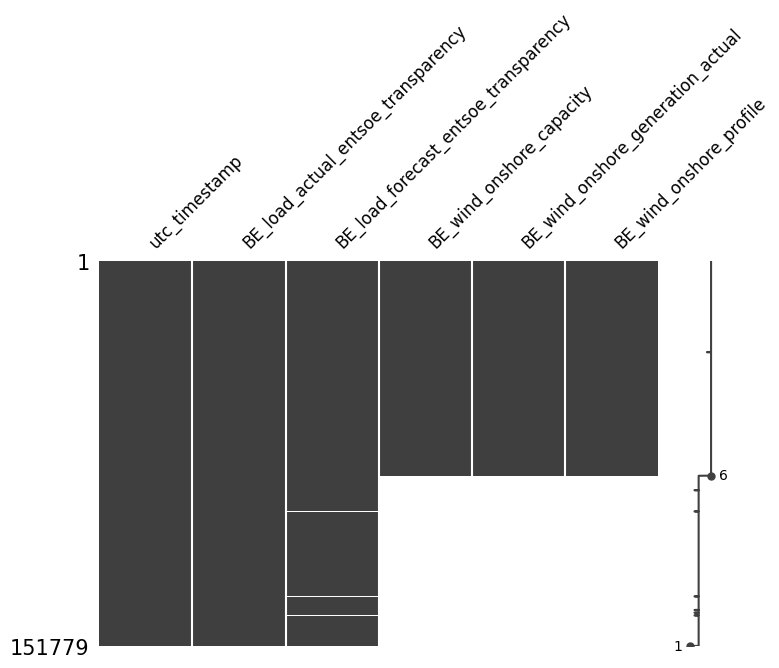

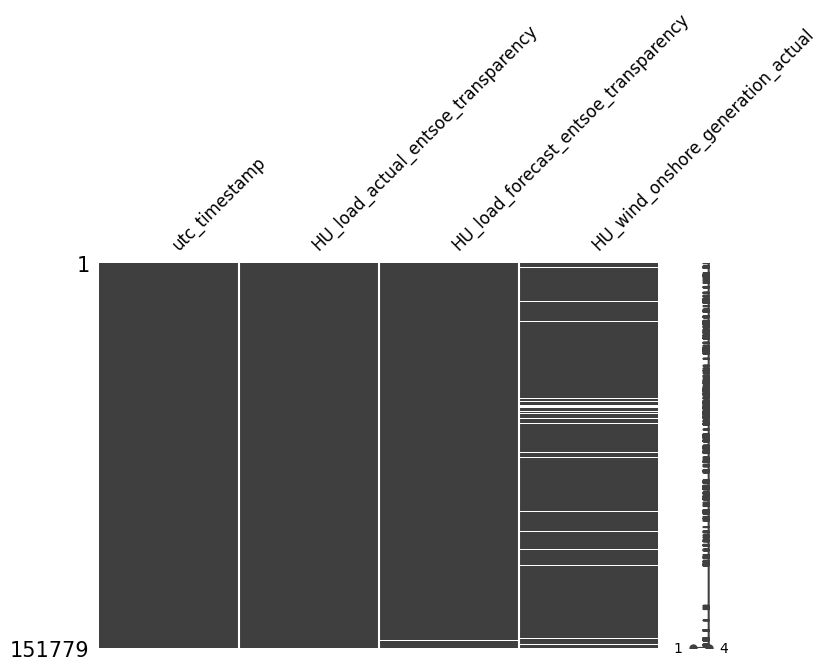

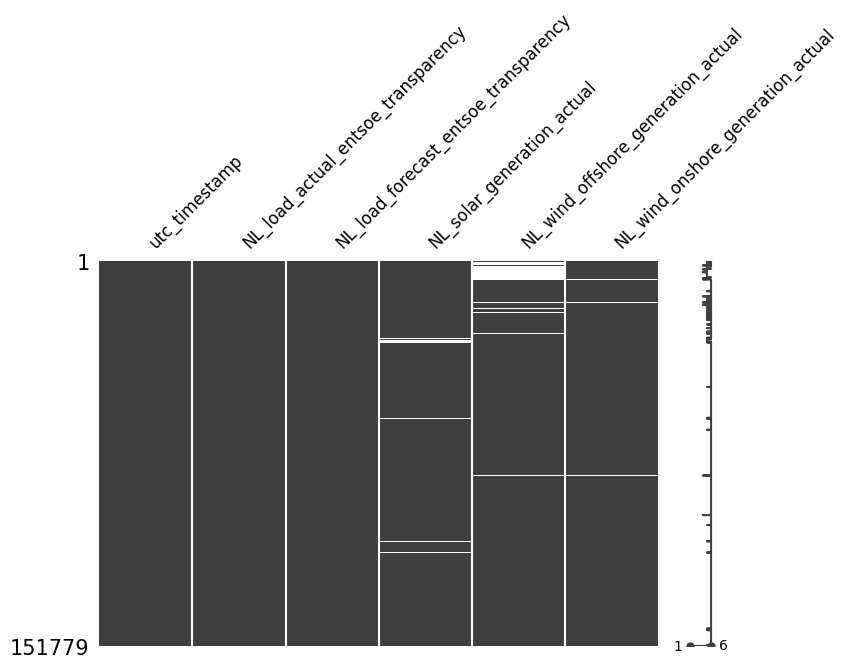

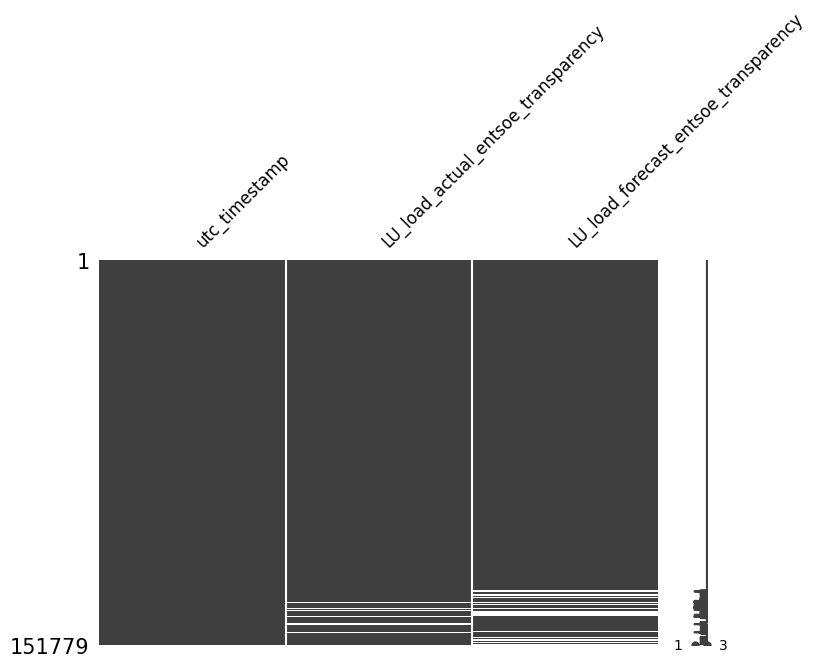

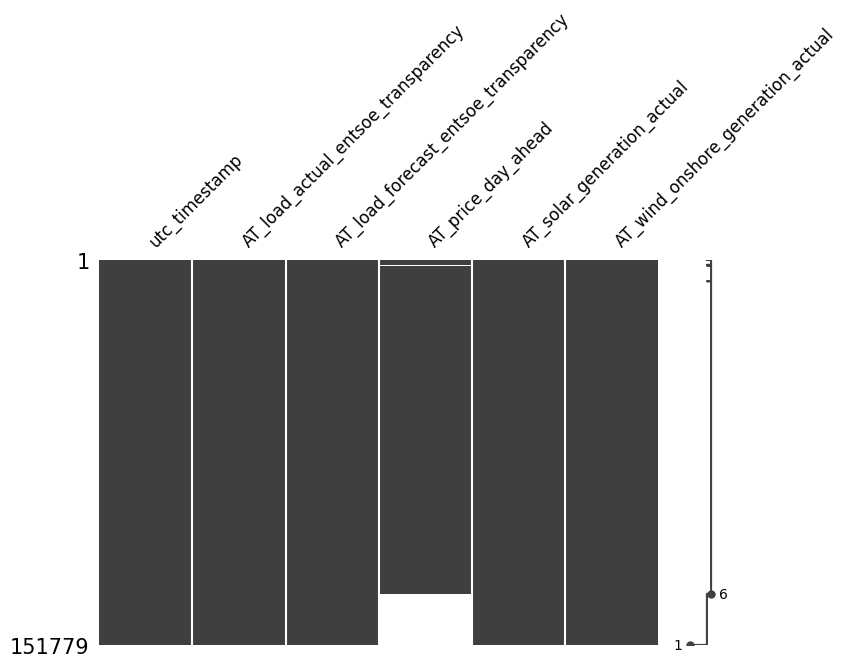

In [21]:
country_dfs_bounded = country_level_variables(energy_15_bounded)
# country_dfs_bounded
country_missing_dt(country_dfs_bounded)

### Main Dataset for analysis

Limiting data to utc_time, country, and load_actual_entsoe_transparency

In [ ]:
# Limit country data to time and load variable
dfs = country_level_variables(energy_15_bounded, load_only=True)
country_actuals = pd.DataFrame({})
for abbreviation, data in dfs.items():
    # Consolidate
    name = abbreviation + '_load_actual_entsoe_transparency'
    # New dataframe with timestamp, country, and load_actual
    data = (data.assign(utc_timestamp = pd.to_datetime(data.utc_timestamp),
                        country = abbreviation)
                .rename(columns = {name: 'load_actual_entsoe_transparency'})
                [['utc_timestamp', 'country', 'load_actual_entsoe_transparency']]) 
    country_actuals = pd.concat([country_actuals, data])

country_actuals = country_actuals.drop_duplicates().reset_index(drop=True)

country_actuals.head()


,utc_timestamp,country,load_actual_entsoe_transparency
0,2014-12-31 23:15:00+00:00,DE,42020.59
1,2014-12-31 23:30:00+00:00,DE,42067.64
2,2014-12-31 23:45:00+00:00,DE,41873.99
3,2015-01-01 00:00:00+00:00,DE,41230.04
4,2015-01-01 00:15:00+00:00,DE,40809.76


### Country Level Electricity Time Series

The following source details the data processing: 
https://github.com/Open-Power-System-Data/time_series/blob/885c0946fe57d1a2f44f7bc57306e87811e4e2e8//processing.ipynb

- Missing data is handled with linear interprolation

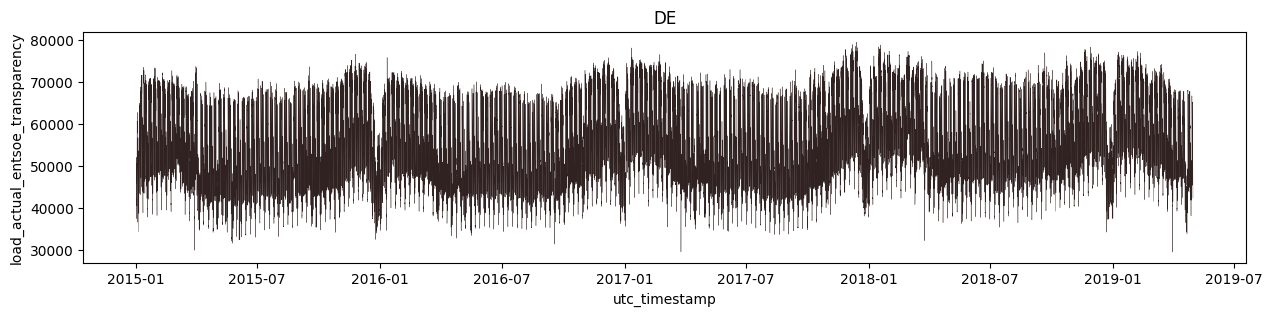

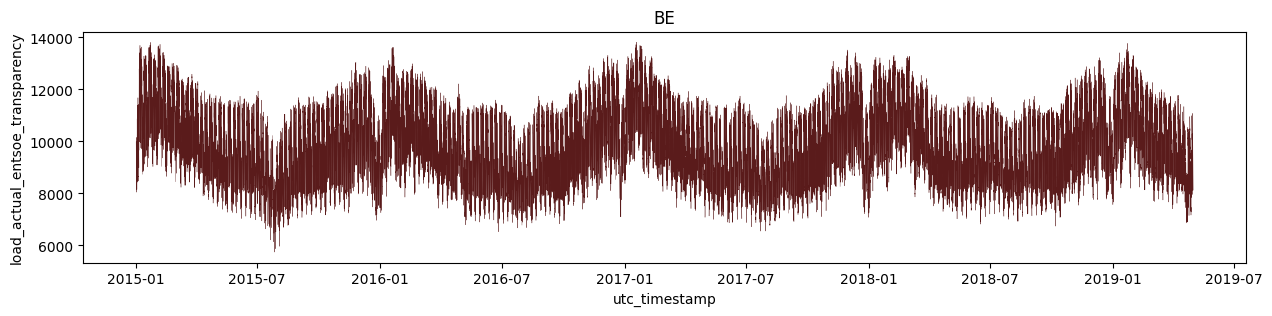

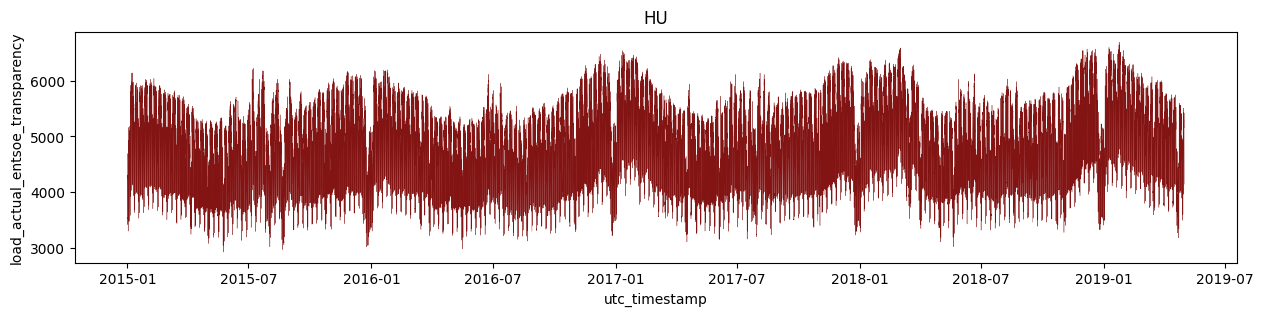

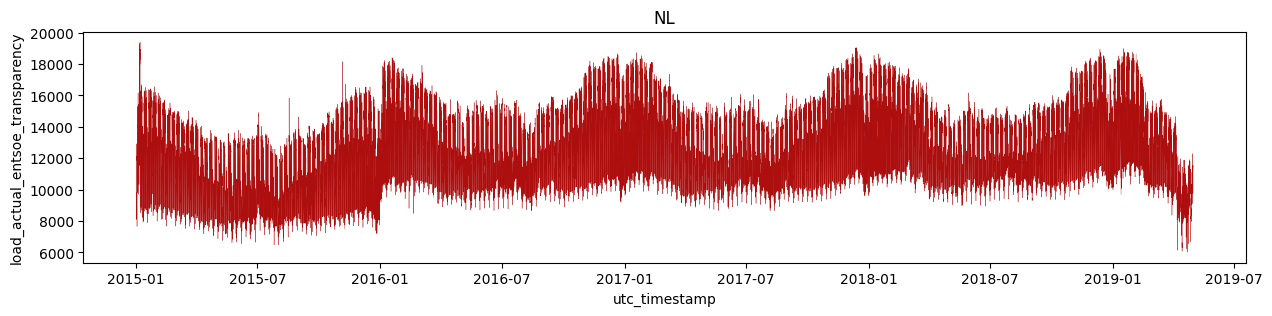

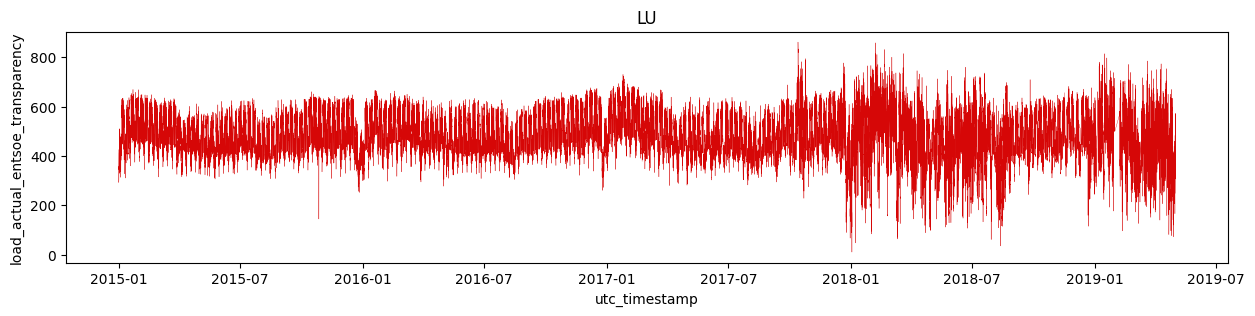

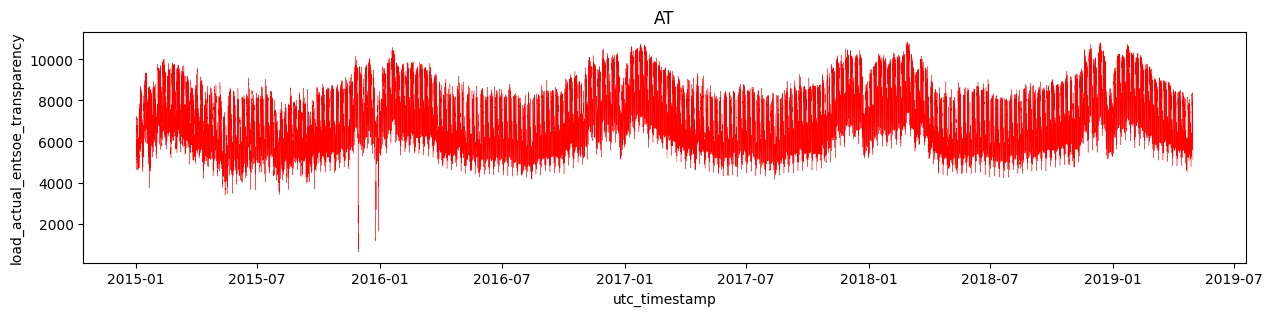

In [24]:
colors = ['#D91A1A', '#B41C1C', '#8F1D1E', '#6B1F20', '#462022', '#212224']
all_countries = country_actuals['country'].unique()
palette = sns.color_palette("dark:red", len(all_countries)) # mako # magma


for country, color in zip(country_actuals['country'].unique(), palette):  
    plot_dt = country_actuals.loc[lambda x: x.country == country]

    _ = plt.figure(figsize=(15, 3))

    _ = sns.lineplot(
        data=plot_dt, 
        x='utc_timestamp', 
        y='load_actual_entsoe_transparency', 
        color=color,
        linewidth=0.25)
    _ = plt.title(country)

    plt.show()

Notes:
- Notable variance and missing data in Lithuania's electricity usage beginning in 2018.

### Country Level Average Daily Load Shapes

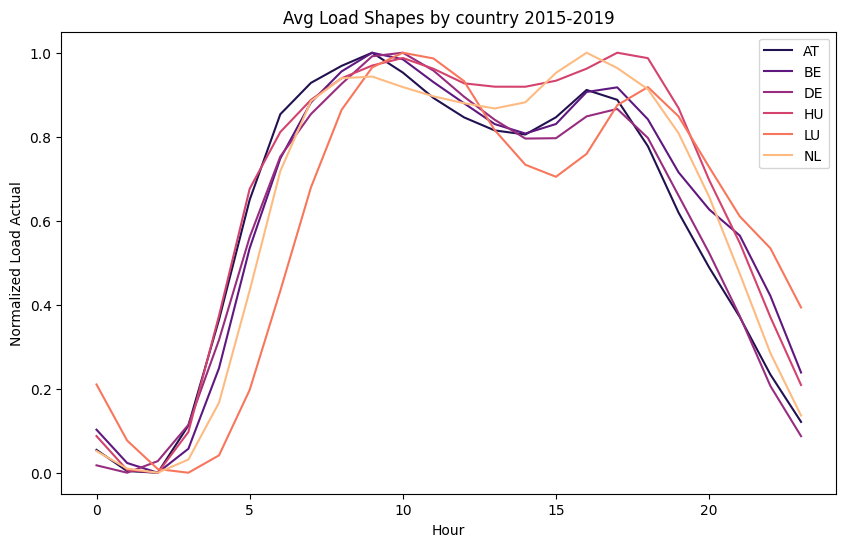

In [39]:
# pivot to so hours are columns 
_ = add_time_features(country_actuals)
day_pivot_hourly = hourly_pivot(country_actuals)
# transform and normalize data for time series plots
avg_hourly = plot_norm_avg_hourly(day_pivot_hourly, 'country')
# plot overlapping load shapes
multi_lineplots(avg_hourly, group='country')

- Normalized Load shapes not split into HDD and CDD
- Lithuania (Orange) is in a different time zone. Moving readings back 1 hour

Shifting Country Actuals for Lithuania back 1 hour

(910674, 910674)

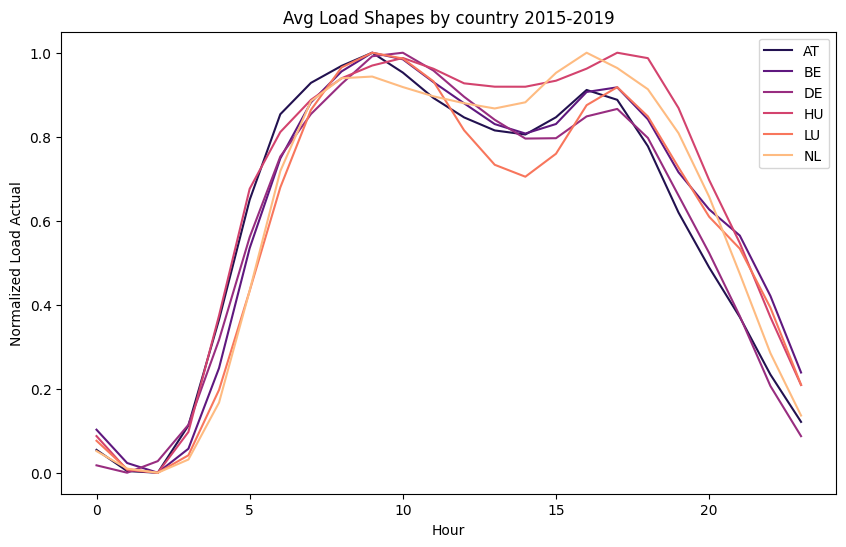

In [41]:
# Adjust Lithuania load shape, insert back into dataframe
LU_time_adjustment = (country_actuals.loc[country_actuals.country == 'LU']
                                     .assign(utc_timestamp = lambda x: x.utc_timestamp - pd.Timedelta(hours=1)))

# Re-insert Lithuania with time adjusted 
country_actuals_LU_adjusted = pd.concat(
    [country_actuals.loc[country_actuals.country != 'LU'], LU_time_adjustment])

# ensure dataframes are of same length
len(country_actuals), len(country_actuals_LU_adjusted)

# add time features (again), transform data for normalized plots
_ = add_time_features(country_actuals_LU_adjusted)
day_pivot_hourly = hourly_pivot(country_actuals_LU_adjusted)
plot_df = plot_norm_avg_hourly(day_pivot_hourly, 'country')
multi_lineplots(plot_df, group='country')


- After the timezone adjustment for Lithuania, the Average Daily loadshapes are similar between countries.
- Lithuania's load shape dips around hours 12-15. 
    - In 2018 Lithuania began integrating their energy grid with the Synchronous grid of Continental Europe. May have affected Lithuania's volatile electricity usage during this time. 

Save Load Data

In [42]:
# data_dir, from the beginning of the notebook
file_path = data_dir + '/datasets/country_energy/country_load.pickle'

with open(file_path, 'wb') as f:
    pickle.dump(country_actuals_LU_adjusted, f)

### Load Shape Longitudinal Clusters

In [ ]:
# Remove 'country' from index for data filtering
day_pivot_hourly_2 = day_pivot_hourly.reset_index() # hourly_pivot(country_actuals_2)

# Seperate to train/test data and validation data
days_remove = (6 * 7) - 1 # Remove 7 days for 6 countries
train_test_clusters = day_pivot_hourly_2.loc[lambda x: ~x.day.isin(day_pivot_hourly_2[-days_remove:]['day'].unique())]

validation = day_pivot_hourly_2[-days_remove:] 

Dataframe with and without Lithuania

In [144]:
train_test_clusters_no_LU = train_test_clusters.loc[lambda x: ~x.country.isin(['LU'])]
len(train_test_clusters), len(train_test_clusters_no_LU)

(9444, 7870)

Tangent: Create clustered load shape feature

In [ ]:
from sklearn.cluster import AgglomerativeClustering as aggclust
import numpy as np
np.random.seed(12)

# Remove warnings when making columns with clusters
pd.options.mode.chained_assignment = None

def assign_n_clusters(df, n):
    '''
    With agglomerative clustering, add 2 to n clusters
    to dataframe
    '''
    # Dataframe of hours 0 through 23
    X = df[list(range(24))]

    # Iterate from clusters 2 to n+1
    for i in range(2,n+1):
        # Column name (based on cluster number i)
        var_name = 'cluster_num_'+str(i)
        # Assign results of hierarchical clustering
        df.loc[:, var_name] = aggclust(
            n_clusters=i,
            linkage='ward' # metric must be euclidean
            ).fit(X).labels_

Add clusters on dataset with and without Lithuania

In [156]:
assign_n_clusters(train_test_clusters, n=6)
assign_n_clusters(train_test_clusters_no_LU, n=6)

In [ ]:
def plot_n_cluster_load_shapes(df, n=6):
    '''
    For n clusters, plot cluster load shapes (normalized from plot_norm_avg_hourly)
    '''
    clusters = []
    for i in range(2,n+1):
        clusters.append(f'cluster_num_{i}')
    # Plot load distribution clusters of cluster num i
    for clust in clusters:
        plot_clusters = plot_norm_avg_hourly(df, clust)
        multi_lineplots(plot_clusters, clust)
        
        # print the percent of values in each cluster 
        print(f"Value Counts when {clust[1]} \n Percents: {(df[clust].value_counts()*100 / (len(df))).round(2)}")

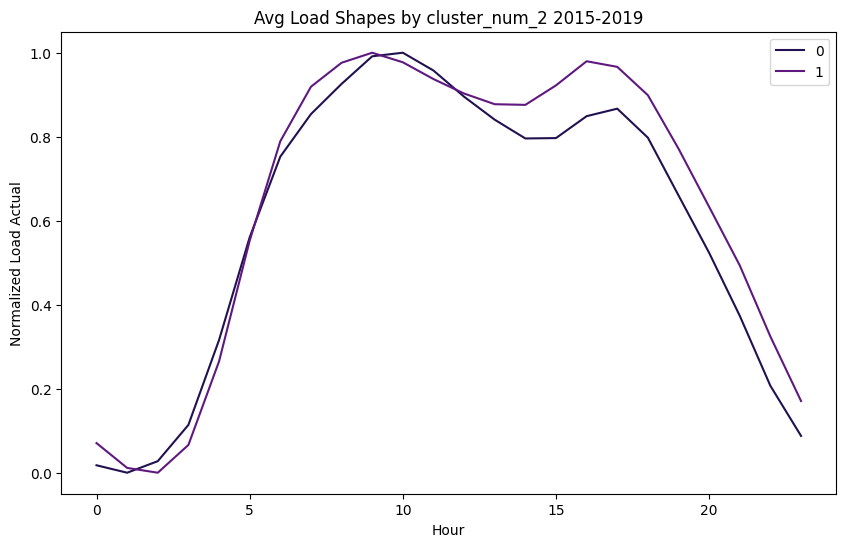

Value Counts when l 
 Percents: cluster_num_2
1    80.0
0    20.0
Name: count, dtype: float64


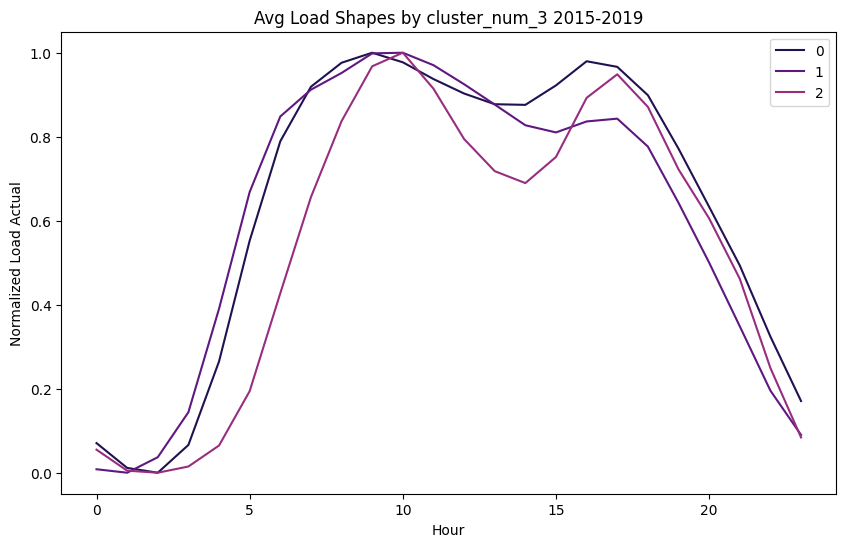

Value Counts when l 
 Percents: cluster_num_3
0    80.00
1    13.28
2     6.72
Name: count, dtype: float64


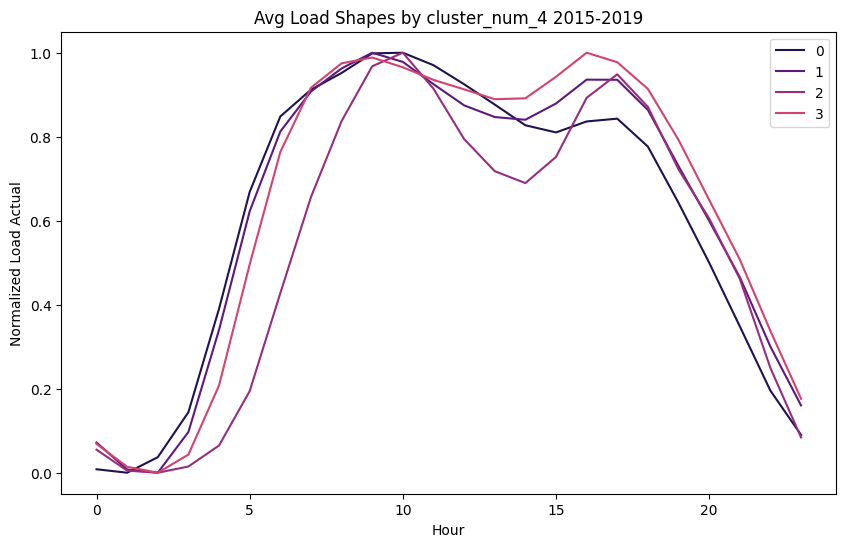

Value Counts when l 
 Percents: cluster_num_4
1    46.11
3    33.89
0    13.28
2     6.72
Name: count, dtype: float64


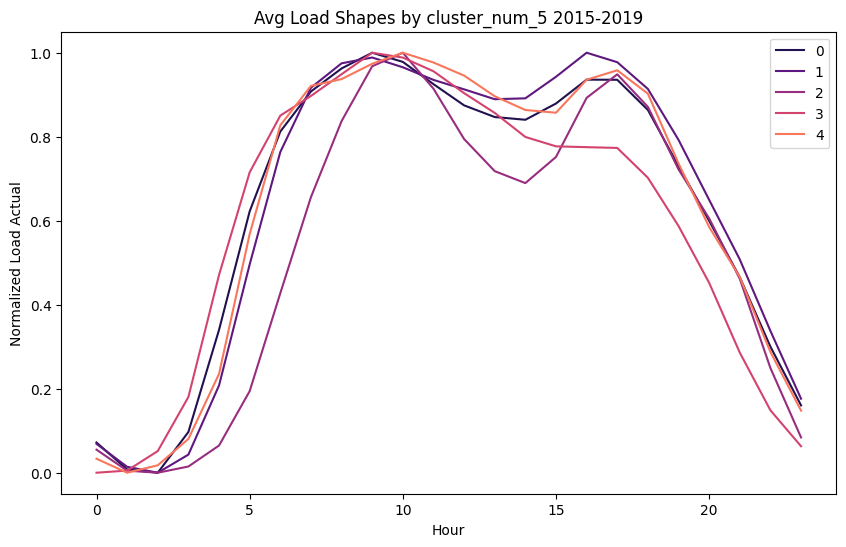

Value Counts when l 
 Percents: cluster_num_5
0    46.11
1    33.89
3     8.54
2     6.72
4     4.74
Name: count, dtype: float64


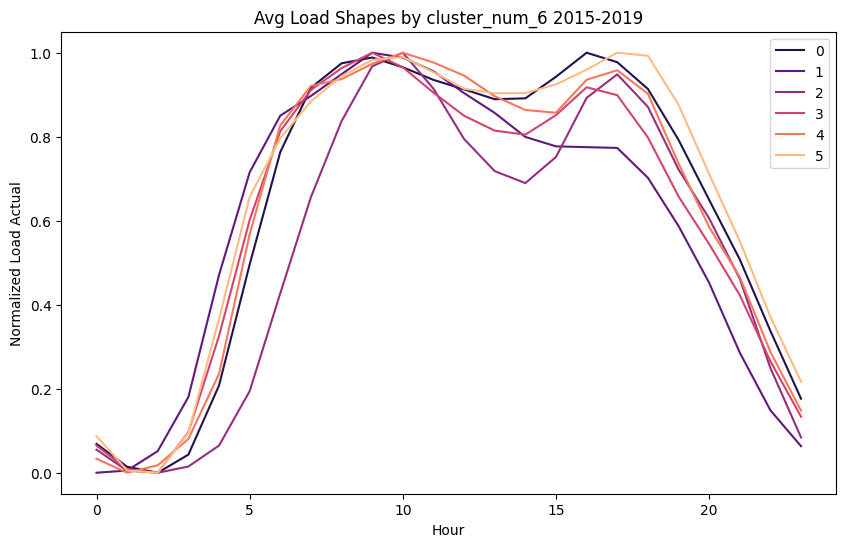

Value Counts when l 
 Percents: cluster_num_6
0    33.89
3    25.81
5    20.30
1     8.54
2     6.72
4     4.74
Name: count, dtype: float64


In [158]:
plot_n_cluster_load_shapes(train_test_clusters_no_LU)
#plot_n_cluster_load_shapes(train_test_clusters)